# Step 1 TEST TEST
## download the data of a index of your choosing and split into training and testing datasets

In [1]:
from AntFolio import download_data, get_tickers, train_test_split, get_pct_returns, get_cum_returns, get_log_returns, transform_to_uniform, benchmark_equal_weights, portfolio_pct_returns, portfolio_cum_returns, portfolio_log_returns, plot_cumulative_returns_portfolio, combine_cumulative_returns

ticker_df = get_tickers('sp500')
data, updated_tickers_df = download_data(ticker_df, '2020-01-01', '2024-01-01')
train, test = train_test_split(data, train_start='2020-01-01', train_end='2021-12-01', test_start='2021-12-01', test_end='2024-01-01')

# add cov function
# add variance function
# the two feed the beta (cov(ri,rm)/variance(rm))
# add beta function where you select the referernce
# add alpha function


[*********************100%***********************]  505 of 505 completed

2024-05-29 15:51:19,917 - ERROR - 
30 Failed downloads:
2024-05-29 15:51:19,918 - ERROR - ['NLOK', 'ATVI', 'DISCK', 'XLNX', 'ABC', 'CERN', 'ANTM', 'NLSN', 'WLTW', 'FB', 'PKI', 'INFO', 'BRK.B', 'BLL', 'DISH', 'DRE', 'FRC', 'CTXS', 'TWTR', 'RE', 'DISCA', 'PBCT', 'FBHS', 'VIAC', 'KSU']: Exception('%ticker%: No timezone found, symbol may be delisted')
2024-05-29 15:51:19,919 - ERROR - ['CDAY', 'FLT', 'PEAK']: Exception('%ticker%: No data found, symbol may be delisted')
2024-05-29 15:51:19,920 - ERROR - ['SIVB']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


2024-05-29 15:51:19,921 - ERROR - ['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2024-01-01)')
2024-05-29 15:51:21,642 - INFO - Tickers identified for removal due to download failures: ['NLOK', 'ATVI', 'DISCK', 'XLNX', 'CDAY', 'ABC', 'FLT', 'CERN', 'ANTM', 'NLSN', 'WLTW', 'SIVB', 'FB', 'PKI', 'PEAK', 'INFO', 'BRK.B', 'BLL', 'DISH', 'DRE', 'FRC', 'CTXS', 'TWTR', 'BF.B', 'RE', 'DISCA', 'PBCT', 'FBHS', 'VIAC', 'KSU']
2024-05-29 15:51:22,346 - INFO - From the initial 505 tickers, 475 were successfully downloaded and retained.


# Step 2
## Create your custom portfolio optimizaiton model and get your weights

In [2]:
from scipy.optimize import minimize
import numpy as np

def markowitz_optimization(train, updated_tickers_df, risk_free_rate=0.02):

    cov_matrix = train.cov()
    mean_returns = train.mean()
    num_assets = len(updated_tickers_df)

    def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
        returns = np.sum(mean_returns * weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (returns - risk_free_rate) / volatility
        return returns, volatility, sharpe_ratio

    def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = tuple((0, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]

    result = minimize(negative_sharpe_ratio, initial_guess, args=(mean_returns, cov_matrix, risk_free_rate),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    optimal_weights = result.x

    return optimal_weights

pct_returns = get_pct_returns(train)
optimal_weights = markowitz_optimization(pct_returns, updated_tickers_df['symbol'].to_list()) 

# Step 2
## Backtest the results on the testing dataset and compare to the benchmark (equally weighted portfolio)

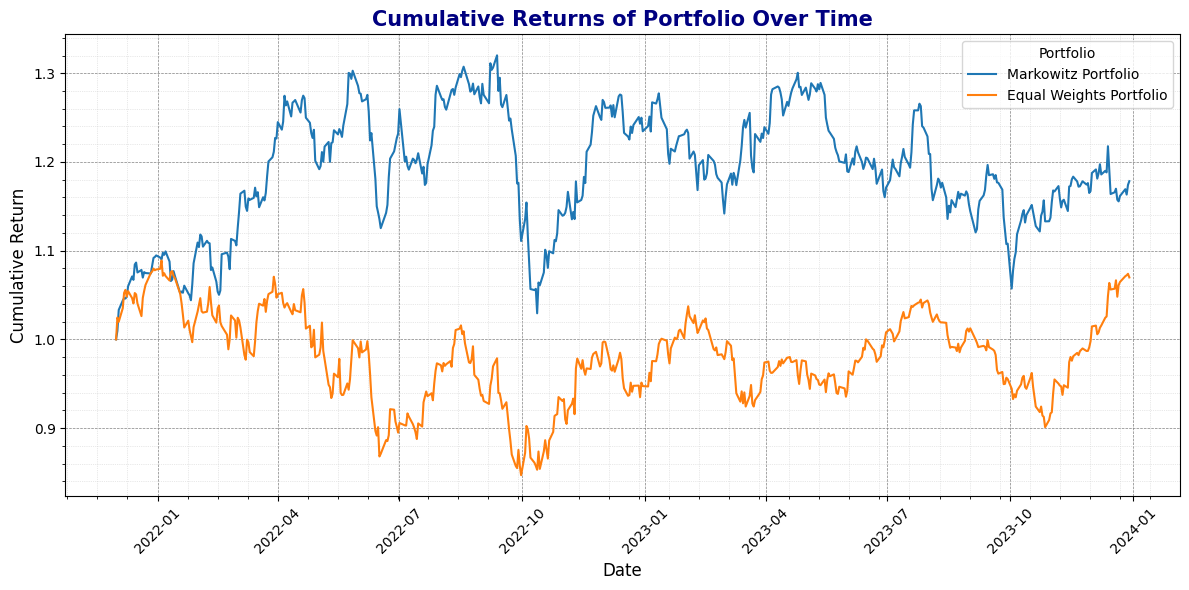

            Markowitz Portfolio  Equal Weights Portfolio
Date                                                    
2021-12-01             1.000000                 1.000000
2021-12-02             1.009623                 1.024640
2021-12-03             1.033231                 1.019881
2021-12-06             1.043752                 1.035129
2021-12-07             1.046446                 1.052356
...                         ...                      ...
2023-12-22             1.161683                 1.064716
2023-12-26             1.169326                 1.071238
2023-12-27             1.163237                 1.072287
2023-12-28             1.174248                 1.073935
2023-12-29             1.178393                 1.069845

[523 rows x 2 columns]


In [3]:
equal_weights = benchmark_equal_weights(updated_tickers_df)

markowitz_cum_returns = portfolio_cum_returns(test, updated_tickers_df, optimal_weights)
equal_weights_cum_returns = portfolio_cum_returns(test, updated_tickers_df, equal_weights)

cum_retu_backtest = combine_cumulative_returns(markowitz_cum_returns, equal_weights_cum_returns, portfolio_names=['Markowitz Portfolio', 'Equal Weights Portfolio'])
plot_cumulative_returns_portfolio(cum_retu_backtest)
print(cum_retu_backtest)